In [1]:
# data access
import earthaccess

# custom tool functions
import importlib
import tools
import makeL3_scripts
importlib.reload(tools)
importlib.reload(makeL3_scripts)
from tools import *
from makeL3_scripts import makeL3, path_to_gridded_ds

# data manipulation
import numpy as np
import xarray as xr
import cf_xarray  # noqa: F401
import rasterio
import rioxarray as rio

from rasterio.enums import Resampling
from tqdm import tqdm

# plotting
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
loc = "SO"
res = 1.0
strres = {1.0:"1deg", 0.1:"0p1deg"}[res]

xlim = {"SEP":[20,3e3], "SO":[3,3e3]}
ylim = {"SEP":[1,3e2], "SO":[1,2e3]}

In [3]:
fileL3 = "/home/jovyan/shared-public/mucloud-hackweek2025-data/harpL3."+loc+"."+strres+".nc"

In [4]:
ds = xr.open_dataset(fileL3)
ds

<xarray.Dataset> Size: 6MB
Dimensions:                                           (time: 174, latitude: 11,
                                                       longitude: 51)
Coordinates:
  * time                                              (time) datetime64[ns] 1kB ...
  * latitude                                          (latitude) float64 88B ...
  * longitude                                         (longitude) float64 408B ...
Data variables: (12/14)
    cloud_bow_droplet_effective_radius                (time, latitude, longitude) float32 390kB ...
    cloud_bow_droplet_effective_variance              (time, latitude, longitude) float32 390kB ...
    cloud_bow_droplet_number_concentration_adiabatic  (time, latitude, longitude) float32 390kB ...
    cloud_bow_liquid_water_path                       (time, latitude, longitude) float32 390kB ...
    cloud_rft_droplet_effective_radius_mode_0         (time, latitude, longitude) float32 390kB ...
    cloud_rft_droplet_effective_radius_mode_1         (time, latitude, longitude) float32 390kB ...
    ...                                                ...
    cloud_rft_mode_fraction_0                         (time, latitude, longitude) float32 390kB ...
    cloud_rft_mode_fraction_1                         (time, latitude, longitude) float32 390kB ...
    cloud_top_altitude                                (time, latitude, longitude) float32 390kB ...
    cloud_top_temperature                             (time, latitude, longitude) float32 390kB ...
    cloud_top_pressure                                (time, latitude, longitude) float32 390kB ...
    cloud_liquid_index_mask                           (time, latitude, longitude) float64 781kB ...
Attributes: (12/110)
    Conventions:                                            CF-1.10
    acquisition_scheme:                                     4
    att_pitch_start_end_degrees:                            [-0.10171989 -0.1...
    att_roll_start_end_degrees:                             [-0.01183303 -0.1...
    att_time_offset:                                        0.0
    att_yaw_start_end_degrees:                              [-20.5951   -14.6...
    ...                                                     ...
    cloud_rft_lut_file_name:                                /sdps/sdpsoper/Sc...
    cloud_rft_scatt_angle_required_min:                     135.83791174582538
    cloud_rft_scatt_angle_required_max:                     150.0
    cloud_rft_scatt_angle_to_use_lo:                        135.83791174582538
    cloud_rft_scatt_angle_to_use_hi:                        165.0
    cloud_rft_decomposition_size_correlation_required_min:  0.95

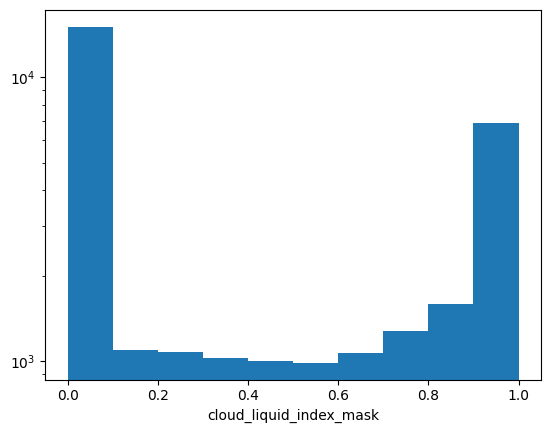

In [5]:
ds.cloud_liquid_index_mask.plot()
plt.yscale("log")

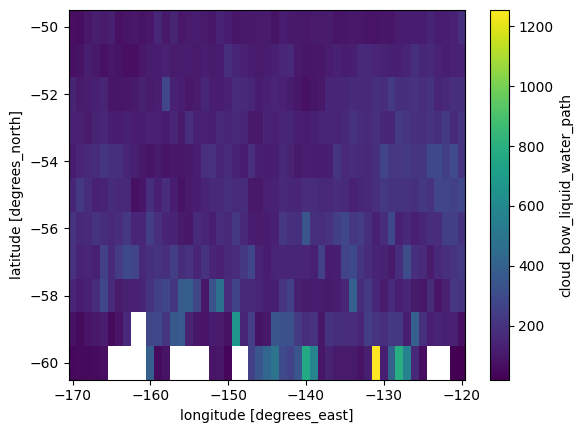

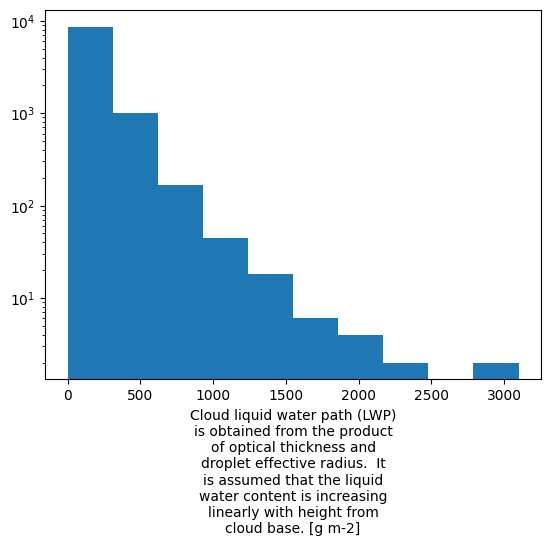

In [6]:
ds.cloud_bow_liquid_water_path.mean("time").plot()
plt.show()
ds.cloud_bow_liquid_water_path.plot()
plt.yscale("log")
plt.show()

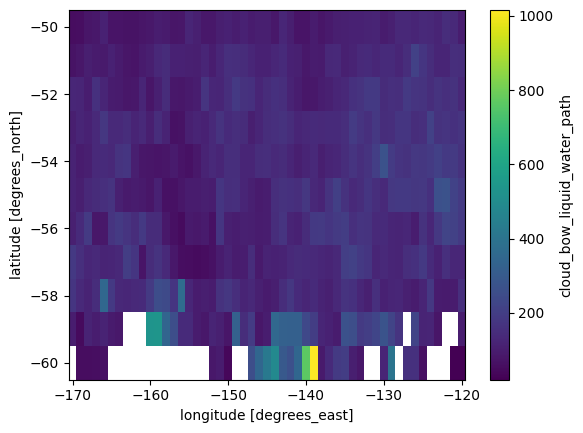

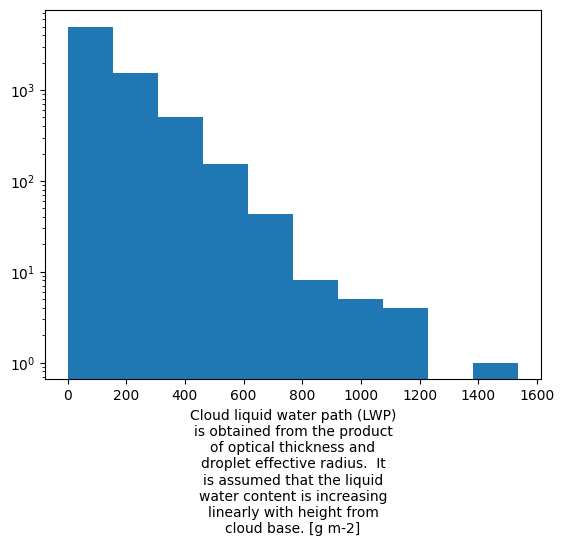

In [7]:
ds_filter = ds.where(ds.cloud_liquid_index_mask > 0.5)
ds_filter.cloud_bow_liquid_water_path.mean("time").plot()
plt.show()
ds_filter.cloud_bow_liquid_water_path.plot()
plt.yscale("log")
plt.show()

In [8]:
ds_filter

<xarray.Dataset> Size: 6MB
Dimensions:                                           (time: 174, latitude: 11,
                                                       longitude: 51)
Coordinates:
  * time                                              (time) datetime64[ns] 1kB ...
  * latitude                                          (latitude) float64 88B ...
  * longitude                                         (longitude) float64 408B ...
Data variables: (12/14)
    cloud_bow_droplet_effective_radius                (time, latitude, longitude) float32 390kB ...
    cloud_bow_droplet_effective_variance              (time, latitude, longitude) float32 390kB ...
    cloud_bow_droplet_number_concentration_adiabatic  (time, latitude, longitude) float32 390kB ...
    cloud_bow_liquid_water_path                       (time, latitude, longitude) float32 390kB ...
    cloud_rft_droplet_effective_radius_mode_0         (time, latitude, longitude) float32 390kB ...
    cloud_rft_droplet_effective_radius_mode_1         (time, latitude, longitude) float32 390kB ...
    ...                                                ...
    cloud_rft_mode_fraction_0                         (time, latitude, longitude) float32 390kB ...
    cloud_rft_mode_fraction_1                         (time, latitude, longitude) float32 390kB ...
    cloud_top_altitude                                (time, latitude, longitude) float32 390kB ...
    cloud_top_temperature                             (time, latitude, longitude) float32 390kB ...
    cloud_top_pressure                                (time, latitude, longitude) float32 390kB ...
    cloud_liquid_index_mask                           (time, latitude, longitude) float64 781kB ...
Attributes: (12/110)
    Conventions:                                            CF-1.10
    acquisition_scheme:                                     4
    att_pitch_start_end_degrees:                            [-0.10171989 -0.1...
    att_roll_start_end_degrees:                             [-0.01183303 -0.1...
    att_time_offset:                                        0.0
    att_yaw_start_end_degrees:                              [-20.5951   -14.6...
    ...                                                     ...
    cloud_rft_lut_file_name:                                /sdps/sdpsoper/Sc...
    cloud_rft_scatt_angle_required_min:                     135.83791174582538
    cloud_rft_scatt_angle_required_max:                     150.0
    cloud_rft_scatt_angle_to_use_lo:                        135.83791174582538
    cloud_rft_scatt_angle_to_use_hi:                        165.0
    cloud_rft_decomposition_size_correlation_required_min:  0.95

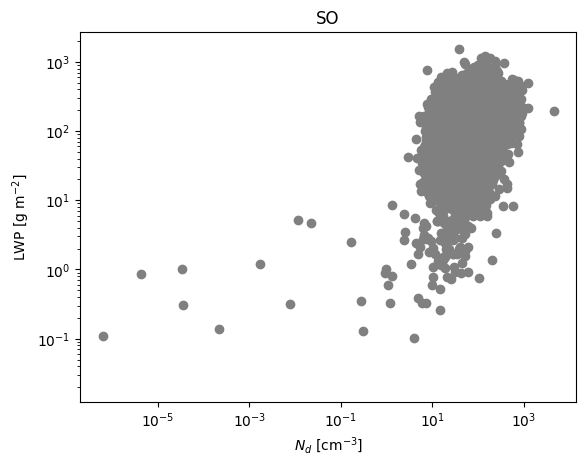

In [9]:
x = ds_filter.cloud_bow_droplet_number_concentration_adiabatic.values.flatten()
y = ds_filter.cloud_bow_liquid_water_path.values.flatten()
mask = ~np.isnan(x) & ~np.isnan(y)

plt.plot(x[mask],y[mask],marker="o", color="grey", ls="")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.title(loc)
plt.show()

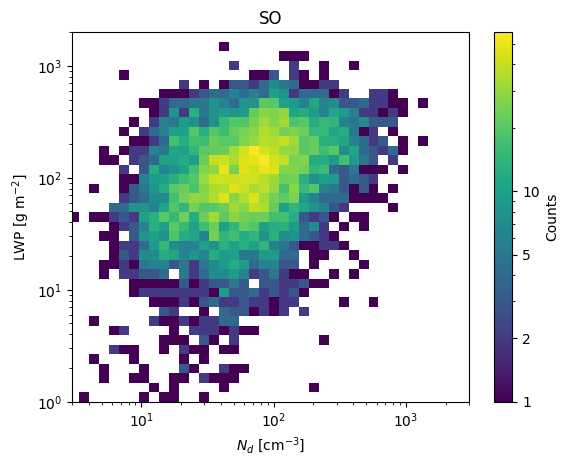

In [10]:
xbins = np.geomspace(1,5000,num=50)
ybins = np.geomspace(1,2000,num=40)

h,xedge,yedge,im = plt.hist2d(x[mask],y[mask], bins=[xbins,ybins], norm=LogNorm())
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
cbar = plt.colorbar(label="Counts")
cbar.set_ticks([1,2,5,10])
cbar.set_ticklabels(["1","2","5","10"])
plt.show()

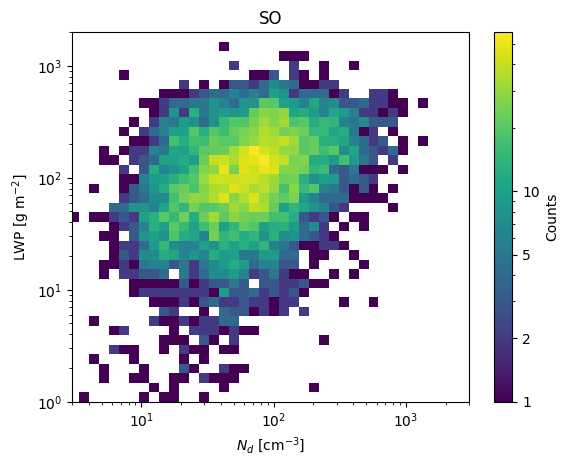

In [11]:
xbins = np.geomspace(1,5000,num=50)
ybins = np.geomspace(1,2000,num=40)

h,xedge,yedge,im = plt.hist2d(x[mask],y[mask], bins=[xbins,ybins], norm=LogNorm())
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
cbar = plt.colorbar(label="Counts")
cbar.set_ticks([1,2,5,10])
cbar.set_ticklabels(["1","2","5","10"])
plt.show()

In [12]:
h.shape

(49, 39)

In [13]:
normfactor = h.sum(axis=1,keepdims=True)
normfactor.shape

(49, 1)

In [14]:
h_norm = h/h.sum(axis=1,keepdims=True)
h_norm.shape

/tmp/ipykernel_1983/3580697624.py:1: RuntimeWarning: invalid value encountered in divide
  h_norm = h/h.sum(axis=1,keepdims=True)


(49, 39)

In [15]:
h_norm.sum(axis=1)

array([nan,  1., nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., nan,  1., nan, nan, nan, nan, nan, nan,  1.])

In [16]:
h_sum = h_norm.cumsum(axis=1)
h_sum.shape

(49, 39)

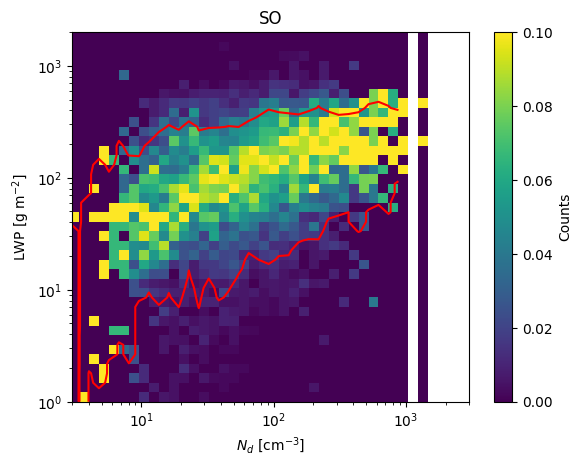

In [17]:
im = plt.pcolormesh(xedge,yedge,h_norm.T,vmax=0.1)
plt.contour(xedge[:-1],yedge[:-1],h_sum.T,levels=[0.05,0.95],colors="r")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
cbar = plt.colorbar(im,label="Counts")
plt.show()

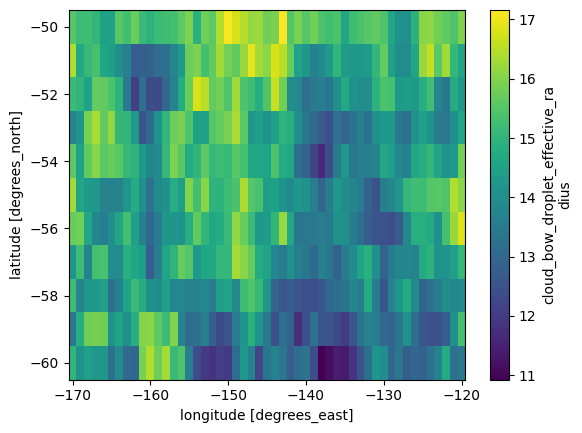

In [18]:
ds_filter.cloud_bow_droplet_effective_radius.mean("time").plot()
plt.contour(xedge[:-1],yedge[:-1],h_sum.T,levels=[0.05,0.95],colors="r")
